In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from TSP_utils import TSP_solver, TSP_plotter, TSP_generator, TSP_loader
import numpy as np
import networkx as nx
import tqdm
import tsplib95
import time
import re
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf


In [3]:
def get_cparams_from_lengths(cparam, delta= 0.005, num_nodes=50):
    # get lengths
    if cparam == 'random':
        folder = 'test_sets/synthetic_n_{}_1000/'.format(num_nodes)
    else:
        folder = 'test_sets/synthetic_n_{}_cparam_{}_delta_{}_1000/'.format(num_nodes, cparam, delta)
    with open(folder+'lengths.txt', 'r') as f:
        lines = f.readlines()
        file_names = [line.split(':')[0].strip() for k, line in enumerate(lines)]
        test_cparams = [float(line.split(':')[-1].strip()) / np.sqrt(1*50) for k, line in enumerate(lines)]
        cparam_dict = dict(zip(file_names, test_cparams))
    return cparam_dict

In [4]:
def get_approx_to_opt_from_file(cparam):
    file_path = 's2v_dqn_results/test_cparam_{}.csv'.format(cparam)
    with open(file_path, 'r') as f:
        lines = f.readlines()
        file_names = [line.split(',')[0].strip() for k, line in enumerate(lines)]
        approx_to_opt = [float(line.split(',')[1].strip()) for k, line in enumerate(lines)]
        approx_dict = dict(zip(file_names, approx_to_opt))
    return approx_dict

In [5]:

def get_approx_and_cparam_lists(cparam):
    approx_dict = get_approx_to_opt_from_file(cparam)
    cparam_dict = get_cparams_from_lengths(cparam)
    approx_list = []
    cparam_list = []
    for key in approx_dict:
        approx_list.append(approx_dict[key])
        cparam_list.append(cparam_dict[key])
    return cparam_list, approx_list


In [10]:
def get_reg_fit_data(cparam_list, approx_list):
    X = np.array(cparam_list)
    X = sm.add_constant(X)
    Y = np.array(approx_list)
    results = sm.OLS(Y, X).fit()
    b = results.params[0]
    a = results.params[1]
    x = np.arange(np.min(cparam_list), np.max(cparam_list), 0.0001)
    y = a * x + b
    # p_value = np.round(results.pvalues[1], 10)
    p_value = results.pvalues[1]
    rsquared = np.round(results.rsquared, 4)
    slope = np.round(a, 6)
    return x, y, p_value, rsquared, slope

In [8]:
cparam = 'random'
cparam_list, approx_list = get_approx_and_cparam_lists(cparam)
x, y, p_value, rsquared, slope = get_reg_fit_data(cparam_list, approx_list)

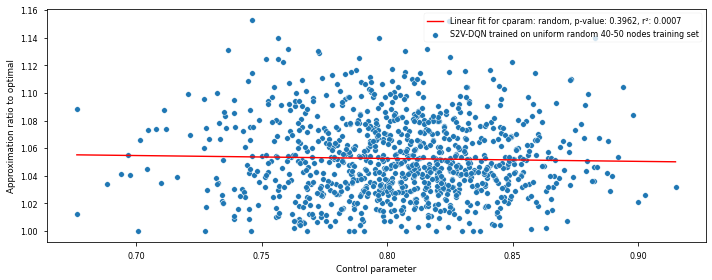

In [9]:
plt.style.use('seaborn-paper')
fig, ax = plt.subplots(1, 1, figsize=(10, 4), sharex=True, sharey=True)
sns.scatterplot(x=cparam_list, y=approx_list, label='S2V-DQN trained on uniform random 40-50 nodes training set', ax=ax)
sns.lineplot(x=x, y=y, color='r', label='Linear fit for cparam: {}, p-value: {}, r²: {}'.format(cparam, p_value, rsquared), ax=ax)
ax.set_ylabel('Approximation ratio to optimal')
ax.set_xlabel('Control parameter')
ax.legend()
plt.tight_layout()
plt.savefig('scatter_approx_vs_cparam_{}.jpg'.format(cparam), dpi=400)

In [1]:
cparams = np.round(np.arange(0.7,0.85,0.01),2)
fig, ax = plt.subplots(1, 1, figsize=(18, 6), sharex=True, sharey=True)
ax.set_ylabel('Approximation ratio to optimal')
ax.set_xlabel('Control parameter')
for k, cparam in enumerate(cparams):
    cparam_list, approx_list = get_approx_and_cparam_lists(cparam)
    x, y, p_value, rsquared, slope = get_reg_fit_data(cparam_list, approx_list)
    sns.scatterplot(x=cparam_list, y=approx_list, label=k*'_'+'S2V-DQN on test set with cparam: {}'.format(cparam), ax=ax)
    sns.lineplot(x=x, y=y, color='r', label='Linear fit for cparam: {}, p-value: {}, r²: {}'.format(cparam, p_value, rsquared), ax=ax)
ax.legend(loc='upper left')
plt.tight_layout()
plt.savefig('scatter_approx_vs_cparams.jpg', dpi=400)


NameError: name 'np' is not defined

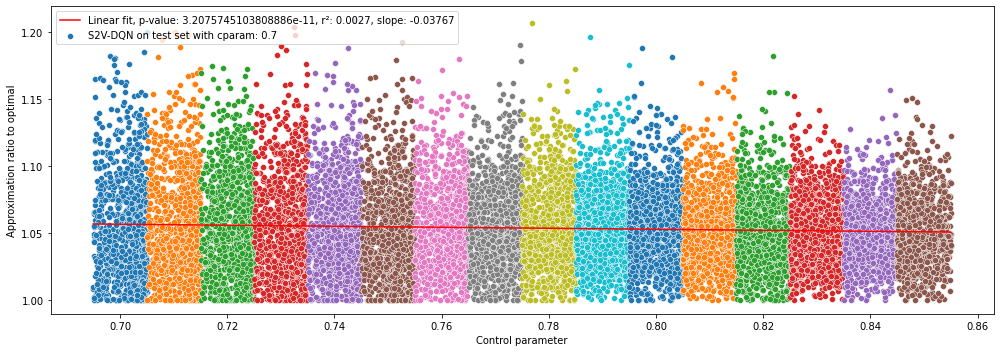

In [11]:
cparams = np.round(np.arange(0.7,0.85,0.01),2)
fig, ax = plt.subplots(1, 1, figsize=(14, 5), sharex=True, sharey=True)
ax.set_ylabel('Approximation ratio to optimal')
ax.set_xlabel('Control parameter')
combined_cparam_list, combined_approx_list = [], []
for k, cparam in enumerate(cparams):
    cparam_list, approx_list = get_approx_and_cparam_lists(cparam)
    sns.scatterplot(x=cparam_list, y=approx_list, label=k*'_'+'S2V-DQN on test set with cparam: {}'.format(cparam), ax=ax)
    combined_cparam_list.extend(cparam_list)
    combined_approx_list.extend(approx_list)
x, y, p_value, rsquared, slope = get_reg_fit_data(combined_cparam_list, combined_approx_list)
sns.lineplot(x=x, y=y, color='r', label='Linear fit, p-value: {}, r²: {}, slope: {}'.format(p_value, rsquared, slope), ax=ax)

ax.legend(loc='upper left')
plt.tight_layout()
plt.savefig('multi_reg_fit_approx_vs_cparams.jpg', dpi=400)

No handles with labels found to put in legend.


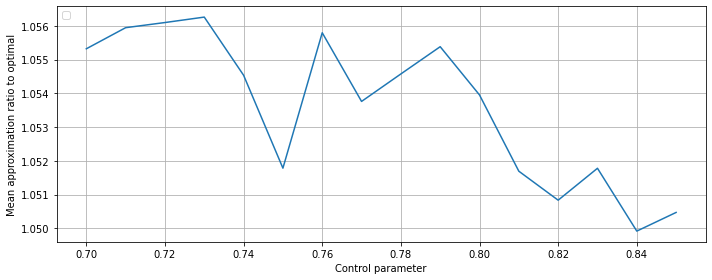

In [15]:
cparams = np.round(np.arange(0.7,0.85,0.01),2)
fig, ax = plt.subplots(1, 1, figsize=(10, 4), sharex=True, sharey=True)
ax.set_ylabel('Mean approximation ratio to optimal')
ax.set_xlabel('Control parameter')
mean_approx = []
mean_cparam = []
for cparam in cparams:
    cparam_list, approx_list = get_approx_and_cparam_lists(cparam)
    mean_approx.append(np.mean(approx_list))
    mean_cparam.append(np.mean(cparam_list))

sns.lineplot(x=cparams, y=mean_approx, ax=ax)
ax.grid(True, axis='both')
ax.legend(loc='upper left')
plt.tight_layout()
plt.savefig('mean_approx_vs_cparam.jpg', dpi=400)


No handles with labels found to put in legend.


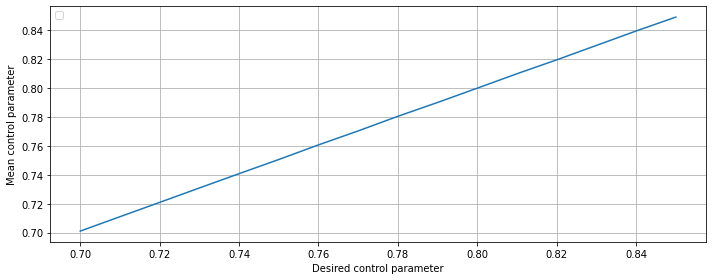

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4), sharex=True, sharey=True)
ax.set_ylabel('Mean control parameter')
ax.set_xlabel('Desired control parameter')
sns.lineplot(x=cparams, y=mean_cparam, ax=ax)
ax.legend(loc='upper left')
ax.grid(True, axis='both')

plt.tight_layout()
plt.savefig('mean_cparam_vs_cparam.jpg', dpi=400)

In [4]:
# evaluate results after specific training
mean_list = []
for run in range(0,20):
    file_path = 's2v_dqn_results/cparam_comparison/train_cparam_0.76_test_cparam_random_run_{}.csv'.format(run)
    with open(file_path, 'r') as f:
        lines = f.readlines()
        file_names = [line.split(',')[0].strip() for k, line in enumerate(lines)]
        approx_to_opt = [float(line.split(',')[1].strip()) for k, line in enumerate(lines)]
        approx_dict = dict(zip(file_names, approx_to_opt))
        mean_list.append(np.mean(approx_to_opt))


In [5]:
# evaluate results after specific training
mean_list_ = []
for run in range(0,30):
    file_path = 's2v_dqn_results/cparam_comparison/train_cparam_0.85_test_cparam_random_run_{}.csv'.format(run)
    with open(file_path, 'r') as f:
        lines = f.readlines()
        file_names = [line.split(',')[0].strip() for k, line in enumerate(lines)]
        approx_to_opt = [float(line.split(',')[1].strip()) for k, line in enumerate(lines)]
        approx_dict = dict(zip(file_names, approx_to_opt))
        mean_list_.append(np.mean(approx_to_opt))

In [14]:
# evaluate results after specific training
mean_list_ = []
for run in range(0,10):
    file_path = 's2v_dqn_results/train_cparam_random_test_cparam_random_run_{}.csv'.format(run)
    with open(file_path, 'r') as f:
        lines = f.readlines()
        file_names = [line.split(',')[0].strip() for k, line in enumerate(lines)]
        approx_to_opt = [float(line.split(',')[1].strip()) for k, line in enumerate(lines)]
        approx_dict = dict(zip(file_names, approx_to_opt))
        mean_list_.append(np.mean(approx_to_opt))

In [15]:
mean_list
#mean_list_

[1.0512591534600002,
 1.0535471772,
 1.05308610802,
 1.052980077,
 1.0566577725500002,
 1.05557064485,
 1.05250093286,
 1.0547787525599999,
 1.05572291866,
 1.05279797825,
 1.0542472015]

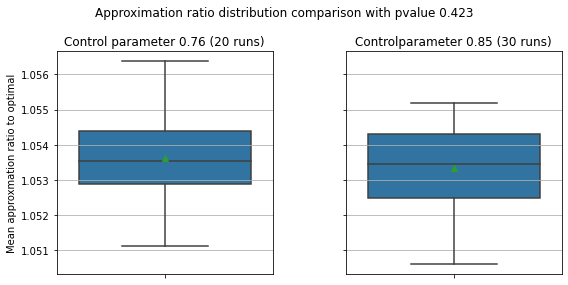

In [7]:
from scipy import stats

pvalue = stats.ttest_ind(mean_list, mean_list_)[1]

fig, axs = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

axs[0].set_ylabel('Mean approxmation ratio to optimal')
sns.boxplot(y=mean_list, ax=axs[0], showmeans=True)

axs[0].grid(True, axis='y')

#axs[1].set_ylabel('Mean approxmation ratio to optimal')
sns.boxplot(y=mean_list_, ax=axs[1], showmeans=True)

axs[1].grid(True, axis='y')
# ax.legend(loc='upper left')
axs[0].set_title('Control parameter 0.76 (20 runs)')
axs[1].set_title('Controlparameter 0.85 (30 runs)')
plt.suptitle(f'Approximation ratio distribution comparison with pvalue {np.round(pvalue,3)}')
plt.tight_layout(w_pad=7)
plt.savefig('n_50_cparam_traning_comparison.jpg', dpi=400)

In [19]:
from scipy import stats

stats.ttest_ind(mean_list, mean_list_)[1]

0.6719883797875981